In [1]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,604257,32.3,1291145,69,1291145,69.0
Vcells,1086061,8.3,8388608,64,1633205,12.5


Loading required package: ggplot2

Loading required package: lattice



In [2]:
setwd("~/lab1/")

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [3]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [4]:
#Genero la clase
dataset[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
dataset[ ,  (kcampos_a_borrar) := NULL    ] 

#Completo missings
dataset[is.na(dataset)] <- 0

Warning message in `[.data.table`(dataset, , ..kclase_nomcampo):
"Both 'kclase_nomcampo' and '..kclase_nomcampo' exist in calling scope. Please remove the '..kclase_nomcampo' variable in calling scope for clarity."


In [5]:
# generacion del modelo
formula  <-  formula(paste(kobjetivo, "~ ."))

In [6]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain <- dtrain[train_rows,]

dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [7]:
#Genero el modelo
t0       <-  Sys.time()
modelo   <-  rpart("clase_ternaria ~ .",   data = dtrain, maxdepth = 5,  cp=0,   xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 7.626724


In [8]:
#Detalles del modelo
modelo

n= 106487 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 106487 1000 CONTINUA (0.004122569 0.005268249 0.990609182)  
   2) ctrx_quarter< 13.5 5511  460 CONTINUA (0.033569225 0.049900200 0.916530575)  
     4) mcuentas_saldo< -1100.705 1981  280 CONTINUA (0.058556285 0.082786471 0.858657244) *
     5) mcuentas_saldo>=-1100.705 3530  180 CONTINUA (0.019546742 0.031444759 0.949008499)  
      10) mpasivos_margen< 6.325 1141   94 CONTINUA (0.029798422 0.052585451 0.917616126)  
        20) Visa_fechaalta>=4532 116   19 CONTINUA (0.043103448 0.120689655 0.836206897)  
          40) Visa_Fvencimiento< -1839 7    3 BAJA+2 (0.000000000 0.571428571 0.428571429) *
          41) Visa_Fvencimiento>=-1839 109   15 CONTINUA (0.045871560 0.091743119 0.862385321) *
        21) Visa_fechaalta< 4532 1025   75 CONTINUA (0.028292683 0.044878049 0.926829268) *
      11) mpasivos_margen>=6.325 2389   86 CONTINUA (0.014650481 0.021347844 0.964001674) *
   3) ctrx_quarter>=13.

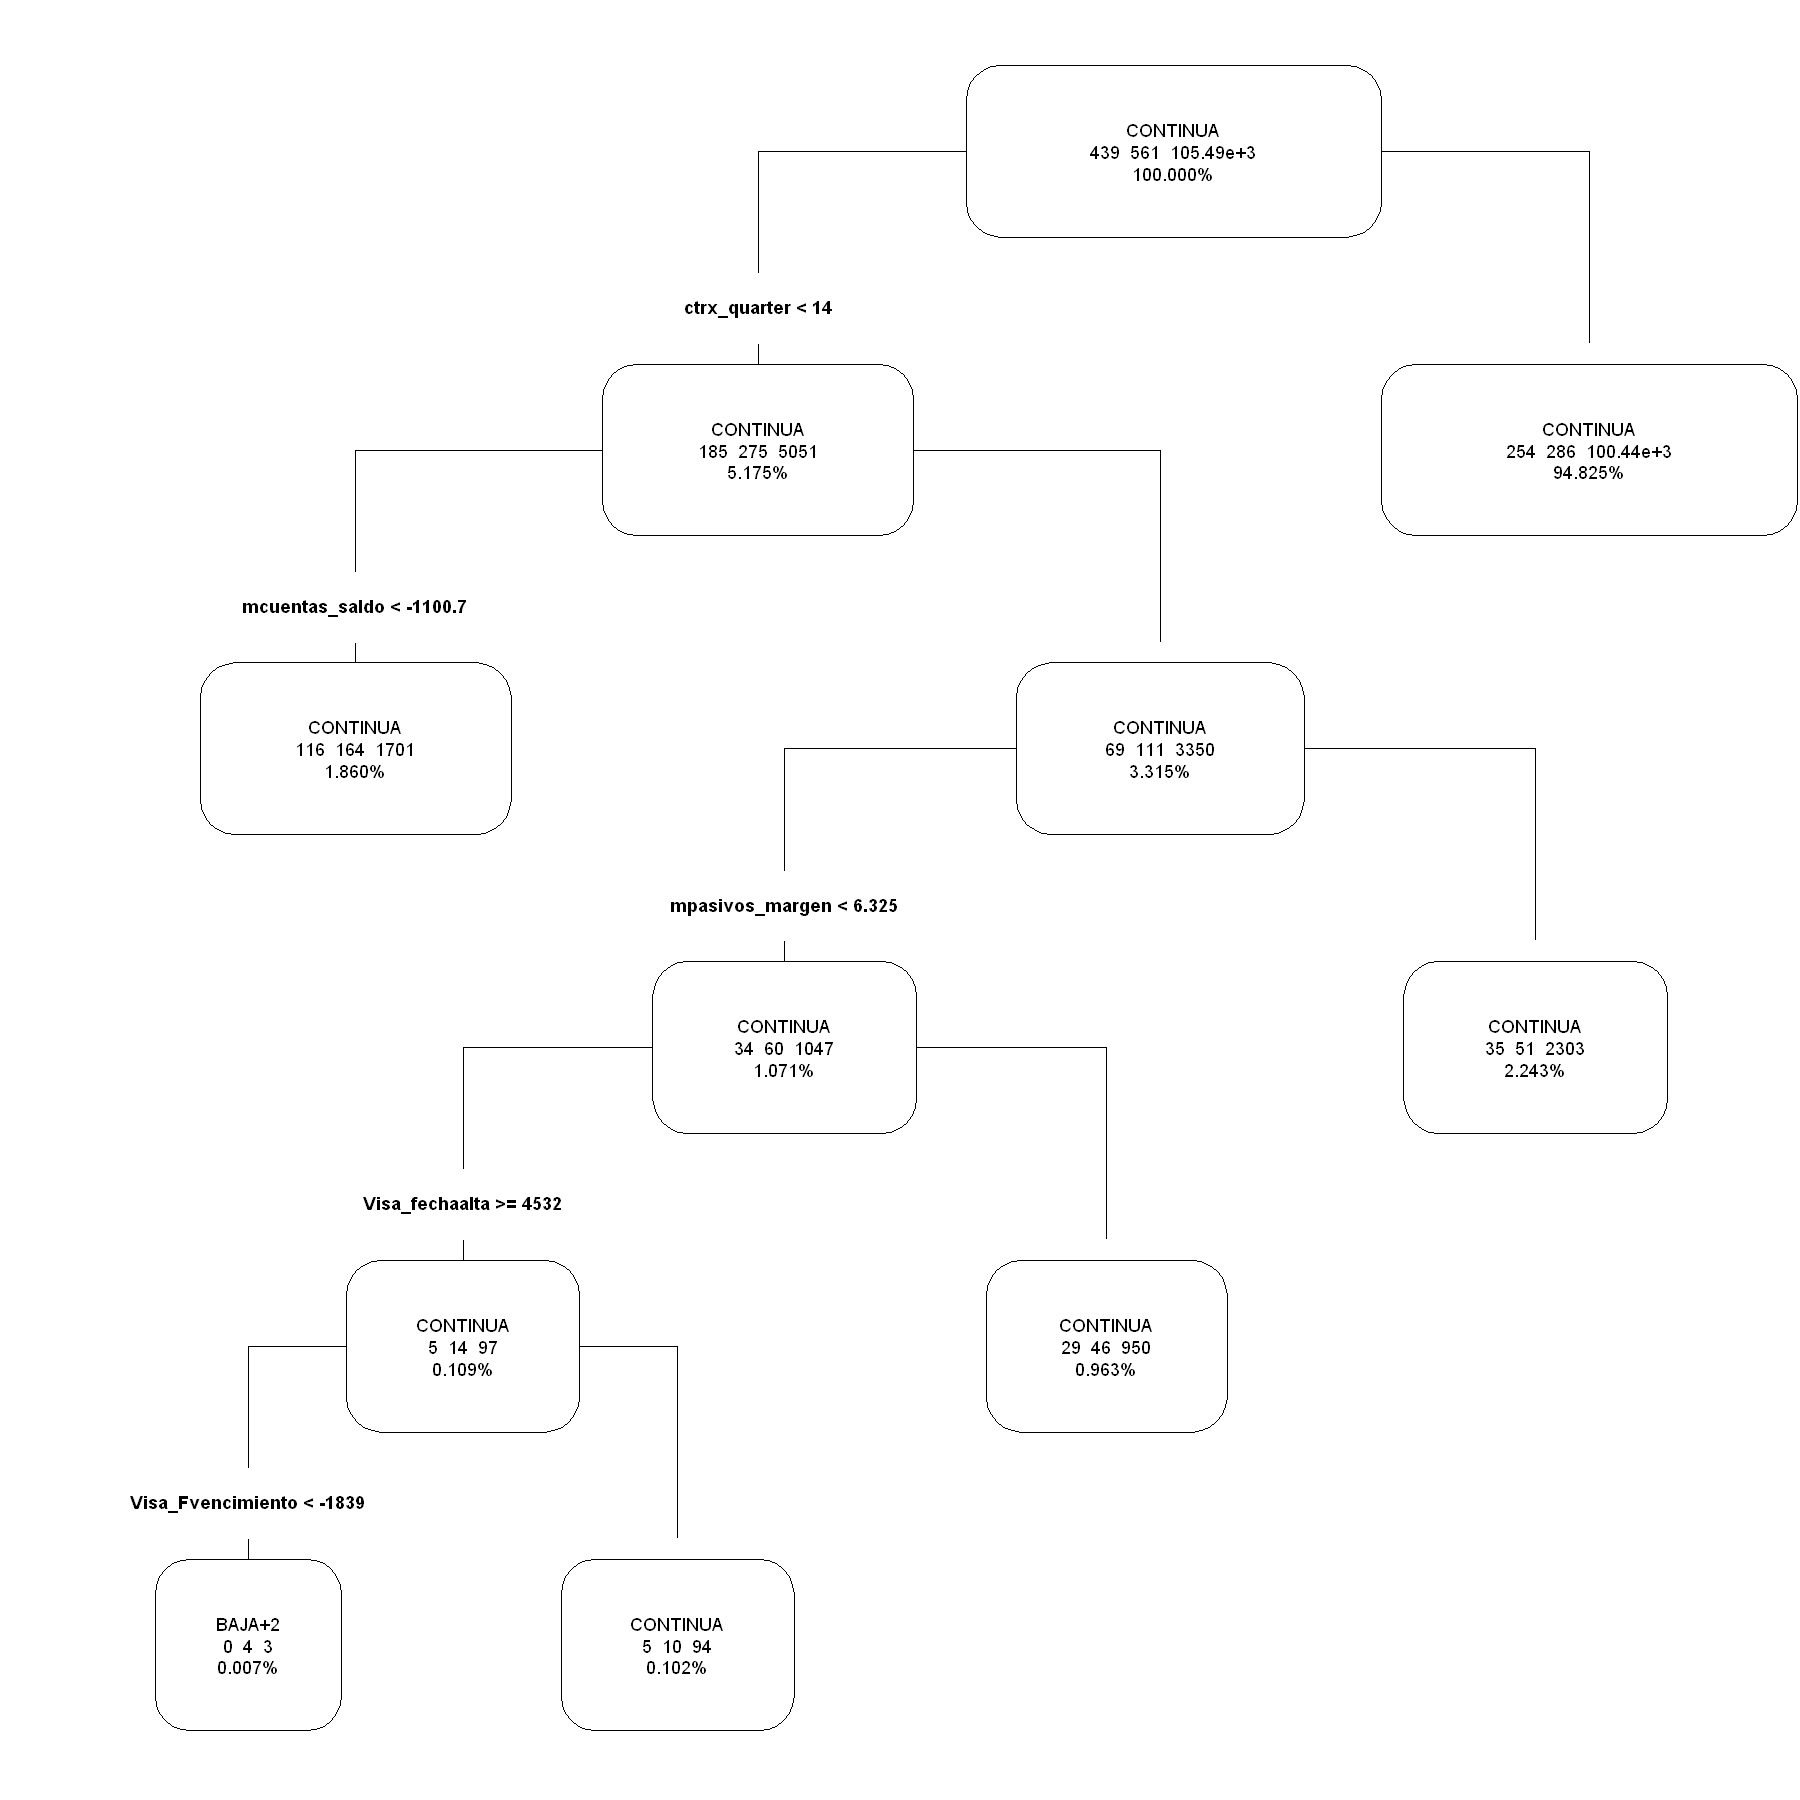

In [9]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [10]:
#Evalúo sobre test
prediccion <- predict(modelo, dtest,) # predicted values

#Calculo ganancia sobre dataset de pruebas
dtest[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtest[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]


#calculo la ganancia de incentivar cada caso
dtest[  , ganancia:= kFPGain ] #-1250
dtest[ clase_ternaria=='BAJA+2',   ganancia:= kTPGain] #48750


#Determino ganancia
print(paste("La Ganancia es:", 3*sum(dtest$Predicted*dtest$ganancia)))

[1] "La Ganancia es: 15168000"


[[1]]
[1] 0.7266374

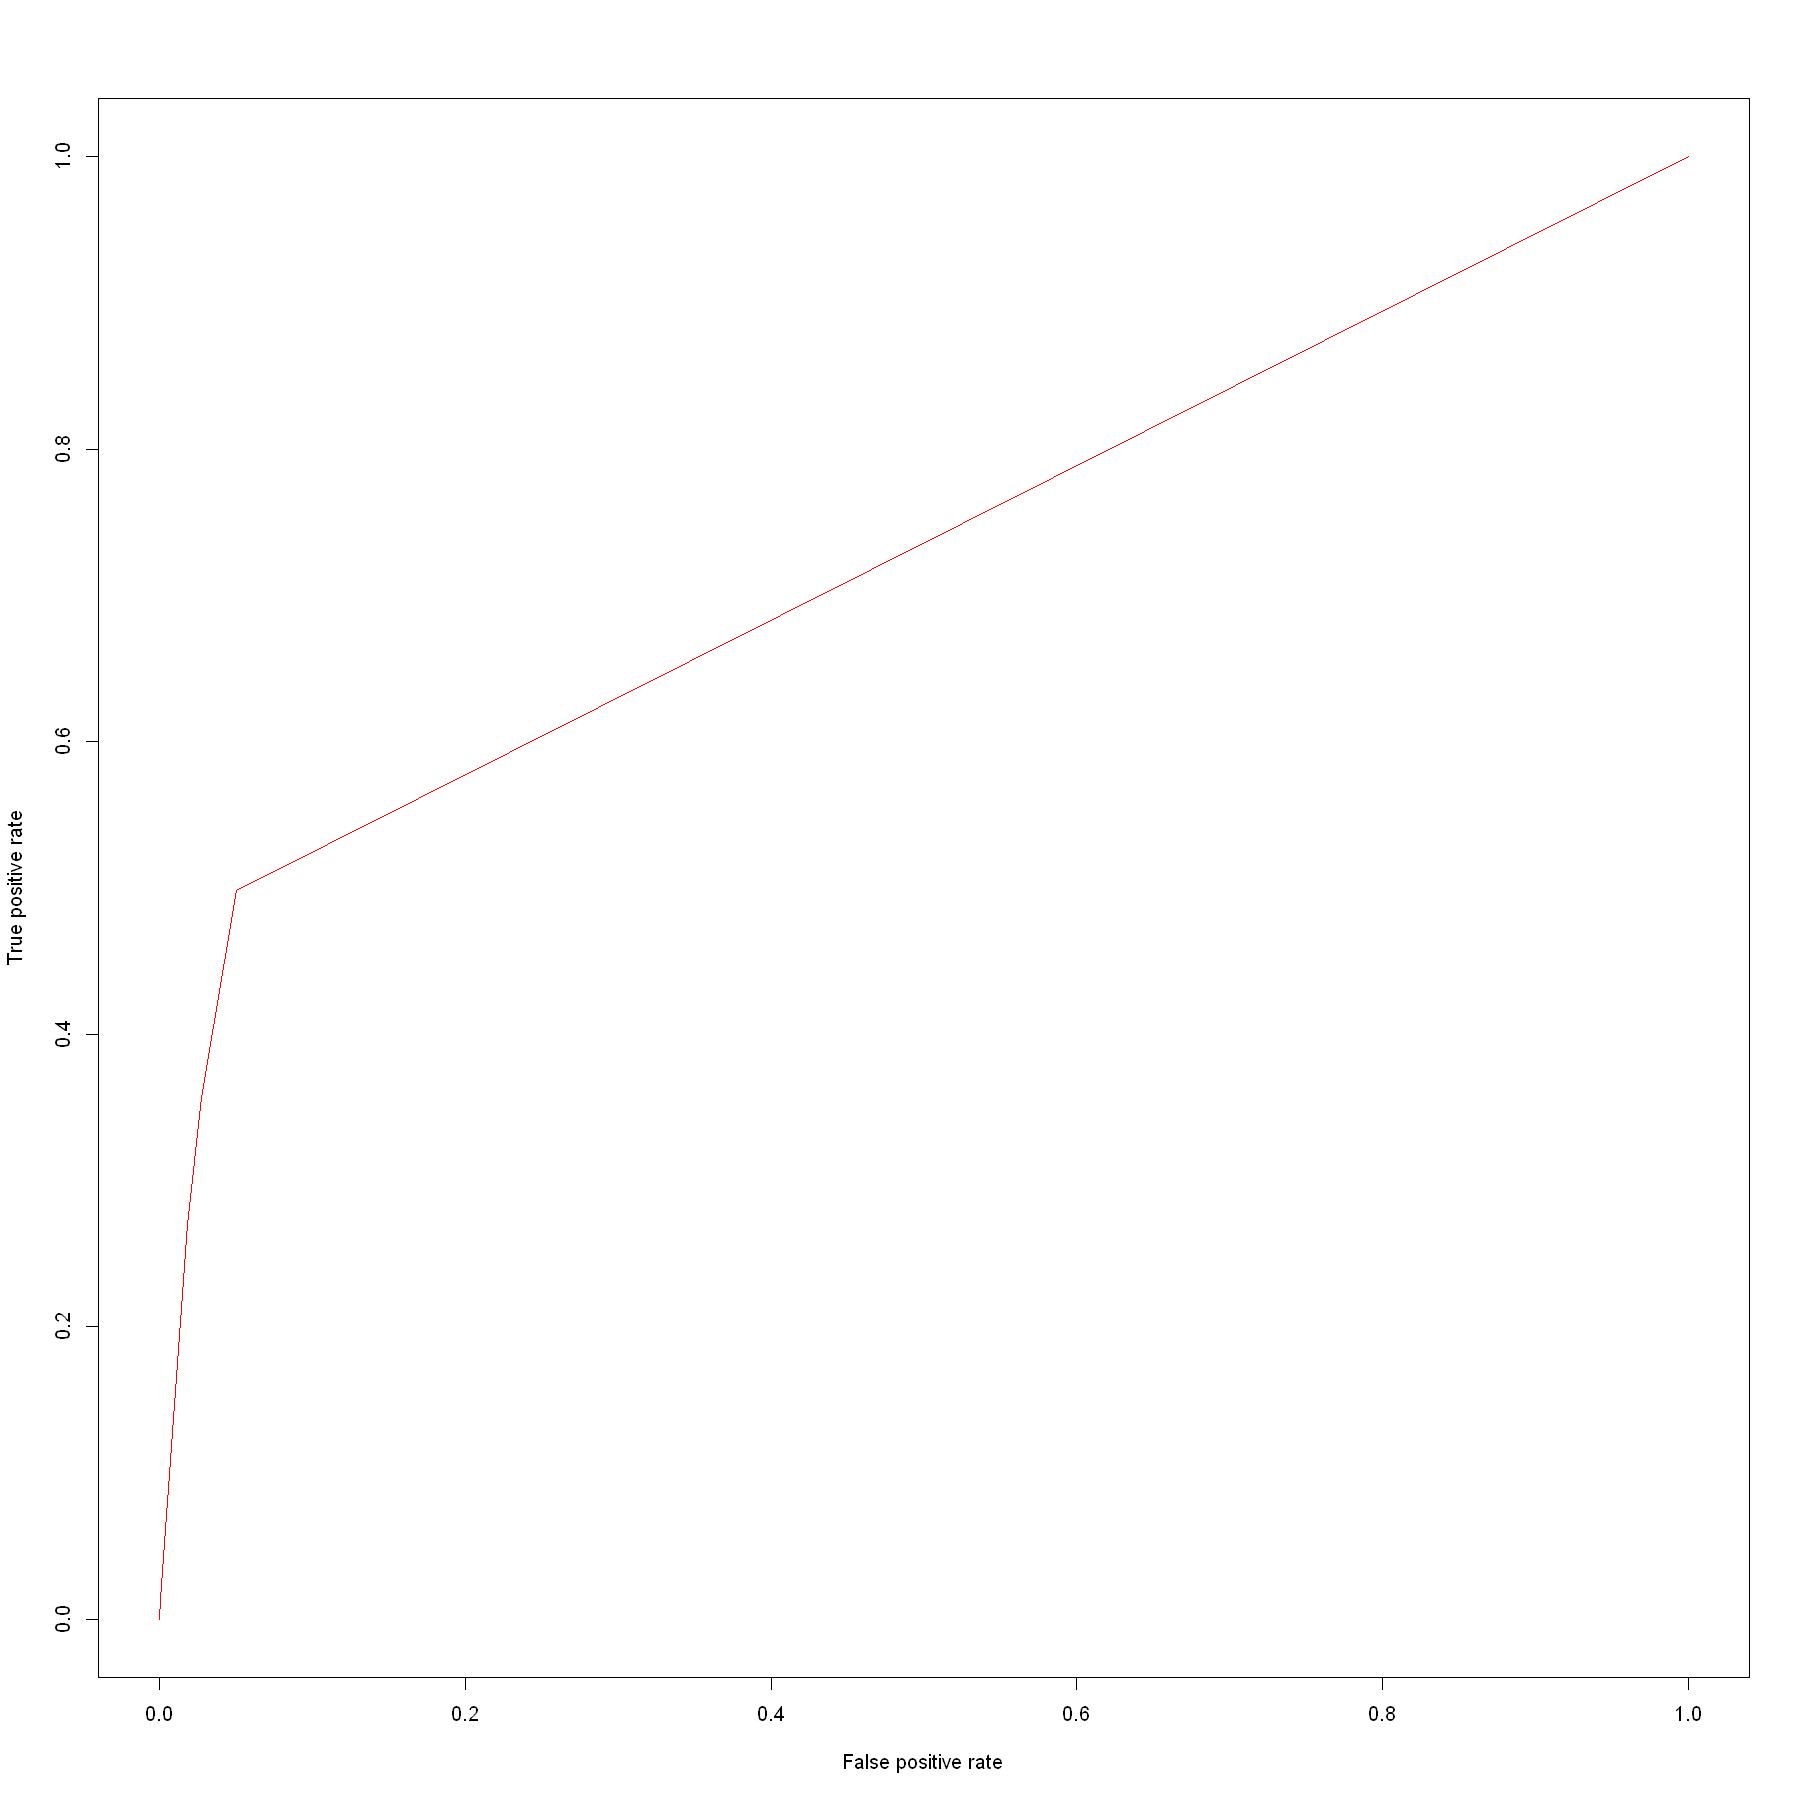

In [11]:
#Calculo las metricas
pred <- prediction(dtest$prob_baja2, dtest$clase_ternaria=='BAJA+2')

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values

[1] 12.39837


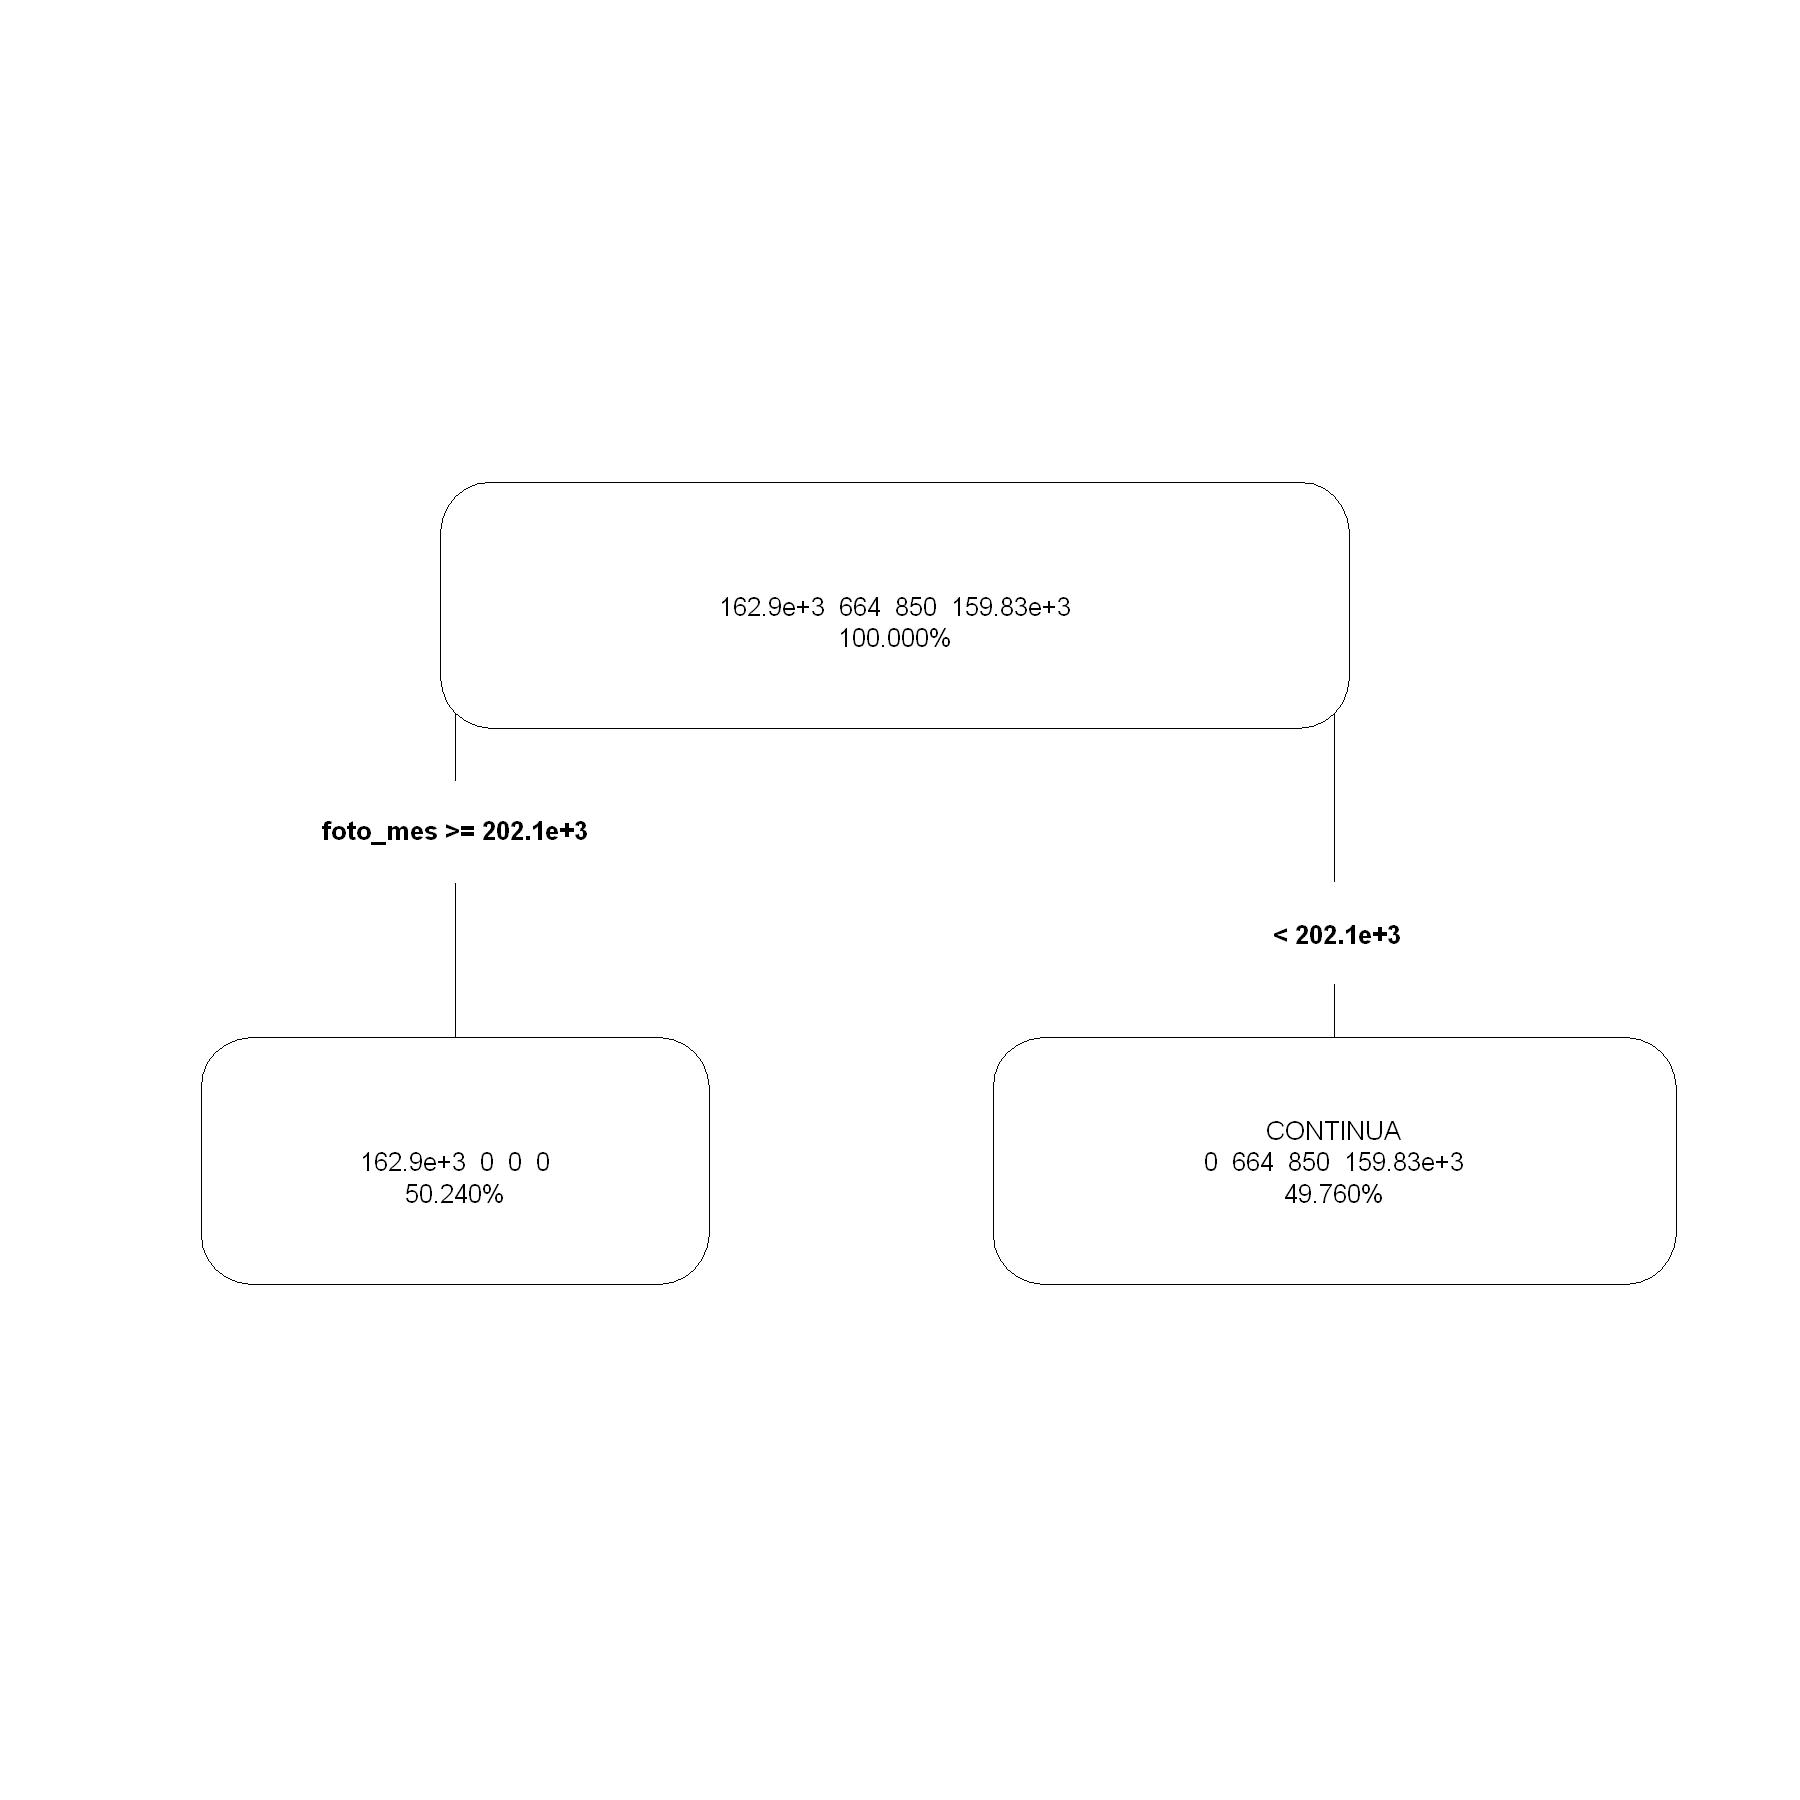

In [12]:
#Genero el modelo sobre dataset completo

t0       <-  Sys.time()
modelo   <-  rpart("clase_ternaria ~ .",   data = dataset, maxdepth = 2,  cp=0,   xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [13]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]
dir.create( "./exp/KA2002" )
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/KA2002/KA2002_001.csv", 
        sep= "," )

Warning message in dir.create("./exp/KA2002"):
"'.\exp\KA2002' already exists"
